In [1]:
!pip install imblearn
#this library for class imbalance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## 1.Load the dataset and explore the variables.
2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.

In [33]:
churn=pd.read_csv('customer_churn.csv')
display(churn.head())
churn['Churn'].value_counts(dropna=False)
#tenure refers to the number of months that a customer has subscribed for.

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


No     5174
Yes    1869
Name: Churn, dtype: int64

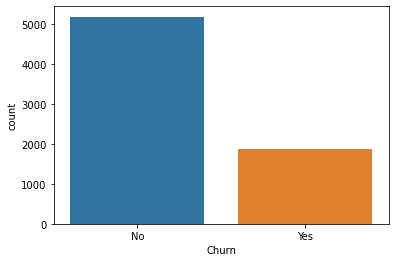

In [9]:
sns.countplot(x='Churn', data=churn);
plt.show()

In [10]:
churn.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 3. Extract the target variable.

In [24]:

Xall=churn[['tenure','SeniorCitizen','MonthlyCharges','Churn']]
Xall

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes
3,45,0,42.30,No
4,2,0,70.70,Yes
...,...,...,...,...
7038,24,0,84.80,No
7039,72,0,103.20,No
7040,11,0,29.60,No
7041,4,1,74.40,Yes


In [25]:
# X/y split
X = Xall.drop('Churn',axis = 1)
y = Xall['Churn']

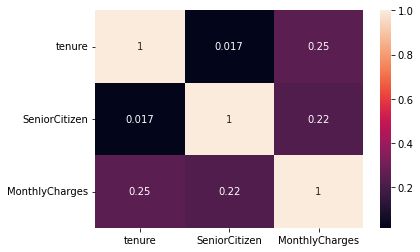

In [26]:
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()
#no significant correlation, we can keep all columns

In [27]:
# here we start scaling, so need to do train-test-split before
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default test_size value is .2

In [28]:
y_train.isna().sum()
y_test.isna().sum()

0

## 4. Extract the independent variables and scale them.

In [29]:
# all features are numeric, so no need to split into _num and _cat. Transformer = scaler
transformer = StandardScaler() #x-meanx/stdx.
transformer.fit(X_train)

X_train_scaled_np = transformer.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)
#X_train.index - it's new to us, if we don;t add anything it's from 0 to value
# because this is the only tranformation we apply to the numerics, (there are no categorical features in the df)
# we can immediately transform the X_test as well
X_test_scaled_np = transformer.transform(X_test) # returns np array
X_test_scaled = pd.DataFrame(X_test_scaled_np , columns=X_test.columns, index=X_test.index)
X_train_scaled.head()
#the first column is original index, if we don't do it, it would be a 0,1,2,3.
#this way we identify the samples


,tenure,SeniorCitizen,MonthlyCharges
3296,-0.340191,-0.435476,-0.514314
6397,0.883210,2.296336,0.017840
6043,-1.196572,-0.435476,-0.819594
5309,1.168670,-0.435476,-1.483535
3000,-0.829552,-0.435476,0.658427


In [30]:
y_train.head()

3296     No
6397     No
6043    Yes
5309     No
3000    Yes
Name: Churn, dtype: object

## Linear relation on logit - what?

In [14]:
# remember linear regression? We expected the relation between x and y to actually be linear!
# should we expect the same from logistic regression?

The logistic transformation was:

$$p = \frac{1}{1+e^{-(b_{0}+b_{1}x_{1}+...)}}$$

If we invert both sides of the equation we get:

$$\frac{1}{p} =1+e^{-(b_{0}+b_{1}x_{1}+...)}$$

Then, we can leave the exponential alone:

$$\frac{1}{p}-1 = e^{-(b_{0}+b_{1}x_{1}+...)}$$

$$log(\frac{1}{p}-1) = -(b_{0}+b_{1}x_{1}+...)$$

Finally, if we take logarithms in both sides of the equation and we change the sign, we get:

$$-log(\frac{1}{p}-1) = (b_{0}+b_{1}x_{1}+...)$$

$$-log(\frac{1}{p}-\frac{p}{p}) = (b_{0}+b_{1}x_{1}+...)$$

$$-log(\frac{1-p}{p}) = (b_{0}+b_{1}x_{1}+...)$$

$$log((\frac{1-p}{p})^{-1}) = (b_{0}+b_{1}x_{1}+...)$$

which is a linear model!

$$log(\frac{p}{1-p}) = (b_{0}+b_{1}x_{1}+...)$$

## 5. Build the logistic regression model.

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=0)

lr.predict(X_train_scaled) -> "Yes/No,Fraud/NoFraud,.."
lr.predict_proba(X_train_scaled)

In [32]:
lr.predict_proba(X_train_scaled) 
# we could do just predict.it gives the actual probabilty to belong to one or the other class
#this array has as many lines as amount of clients in train set
#for the first guy [0.83, 0.16], the probability is high -0.83 for yes, for him to be a tenure

array([[0.83055757, 0.16944243],
       [0.88959148, 0.11040852],
       [0.66558189, 0.33441811],
       ...,
       [0.98794797, 0.01205203],
       [0.25884511, 0.74115489],
       [0.79626532, 0.20373468]])

Let's compute the logarithm shown below:

$$log(\frac{p}{1-p})$$

In [93]:
logits = np.log(lr.predict_proba(X_train_scaled)[:,1]/(1-lr.predict_proba(X_train_scaled)[:,1]))
#we count here this formula, we kknow on the right side is linear model
# we make a picture - and here we go. glucose - yes

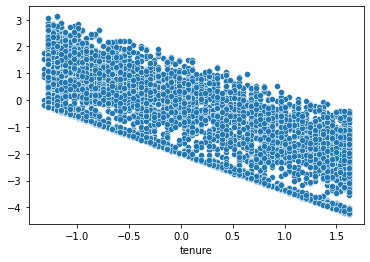

In [94]:
sns.scatterplot(y = logits,x = X_train_scaled['tenure']);
plt.show()
#This is an interesting correlation, when tenure grows, the churn is goin down

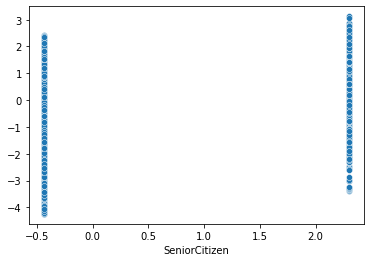

In [95]:
sns.scatterplot(y = logits,x = X_train_scaled['SeniorCitizen']);
plt.show()

# there is no linear correlation -  we should remove this column
#actually interesting to read this graph with Ignacio

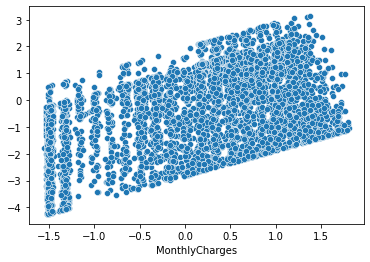

In [96]:
sns.scatterplot(y = logits,x = X_train_scaled['MonthlyCharges']);
plt.show()
#here we can see that there is a strong correlation between Monthlu Charges, and probability to become a churn
#what is expected

No     5174
Yes    1869
Name: Churn, dtype: int64


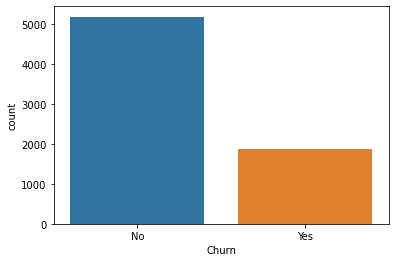

In [97]:
# while there are more imbalanced datasets, we have a significant imbalance
# and the cost of failing to detect the minority class is quite high 
count_classes = churn['Churn'].value_counts()
print(count_classes)
sns.countplot(x = 'Churn', data = churn);
plt.show()

In [98]:
print("The class imbalance ratio is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1])))

The class imbalance ratio is: 0.47


We have a really big class imbalance!!!

In [99]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(X_train_scaled, y_train)
print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_test_scaled, y_test)))

The accuracy of the model in the TEST set is: 0.78


In [100]:
#while accuracy is not absolutely terrible, a closer look reveals some serious problems
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

y_pred_test = lr.predict(X_test_scaled)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test, pos_label="Yes")))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test,pos_label="Yes")))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test,pos_label="Yes")))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))
#kappa is not so good


The accuracy in the TEST set is: 0.78
The precision in the TEST set is: 0.61
The recall in the TEST set is: 0.46
The F1 in the TEST set is: 0.52
The Kappa in the TEST set is: 0.38


## 6.Evaluate the model. 
Accuracy - is nice, but the rest of coeff. is not very high. Due to imbalance data. Or maybe our model is not good to answer this question. Maybe we need to use other variables, to find better prediction.

## 7. Even a simple model will give us more than 70% accuracy. Why?
Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. Accuracy is high, when you have symmetric datasets where values of false positive and false negatives are  similar, what is true in our case.

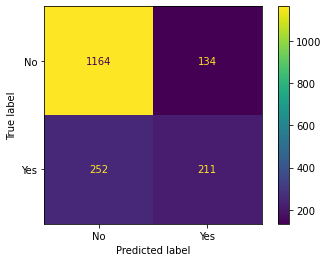

In [101]:
#we fail to identify 40%+ of diabetes cases!
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()
#By looking at this confusion matrix we can say that we are good at predicting 'No'. What was also seen in the data, we 
#have more No than Yes

## 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

# SMOTE

In [107]:
from imblearn.over_sampling import SMOTE

In [110]:

sm = SMOTE(random_state=100,k_neighbors=3)

X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

In [111]:
print(X_train.shape)
print(X_train_SMOTE.shape)

(5282, 3)
(7752, 3)


In [112]:
y_train_SMOTE.value_counts()

No     3876
Yes    3876
Name: Churn, dtype: int64

In [113]:
# yet another small improvement, but bear in mind that we saved 12 hypothetical people with
# these "small improvements"
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_test = lr.predict(X_test_scaled)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test,pos_label='Yes')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test,pos_label='Yes')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test,pos_label='Yes')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

#These are the data before the SMOTE:
#The accuracy in the TEST set is: 0.78
#The precision in the TEST set is: 0.61
#The recall in the TEST set is: 0.46
#The F1 in the TEST set is: 0.52
#The Kappa in the TEST set is: 0.38
#Recall looks much better and F1 became 0,57, but the rest of the coefficients went down.
#Recall (Sensitivity) - Recall is the ratio of correctly predicted positive 
#observations to the all observations in actual class - yes. 
#F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false 
#positives and false negatives into account. Intuitively it is not as easy 
#to understand as accuracy, but F1 is usually more useful than accuracy, especially 
#if you have an uneven class distribution. 


The accuracy in the TEST set is: 0.72
The precision in the TEST set is: 0.48
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.57
The Kappa in the TEST set is: 0.38


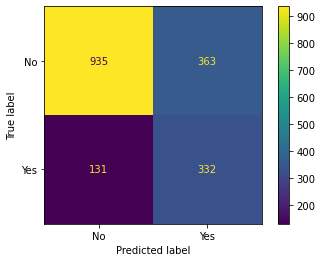

In [114]:
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

In [115]:
list(zip(list(X_test.columns), list(np.abs(lr.coef_)[0])))
#the columns should be in the same range. abs(lr.coef) - we don;t care that its minus or plus
#p/(1-p)=a+b*x1+c*x3... So those coeff at the bottom -is our a,b,c. And they tell us the coef.who contributes the mosr
#tenure has the most impact and after Monthly Charges. SeniorCitizen is less important.

[('tenure', 1.3785756750229383),
 ('SeniorCitizen', 0.27465611292291486),
 ('MonthlyCharges', 0.9487198839149513)]